# Computer Vision Project - Rookie OCR

#### Pre-Requisite: Tesseract OCR
Installation Steps:
- Link -> [Tesseract OCR for Windows](https://github.com/tesseract-ocr/tesseract/releases/download/5.5.0/tesseract-ocr-w64-setup-5.5.0.20241111.exe)
- Install Tesseract OCR on your machine
- Add the path of tesseract.exe to the environment variable (PATH)

#### Configuring Py-Teseract
##### --oem 3 (OCR Engine Mode):
Tells Tesseract which OCR engine(s) to use:
- 0: Legacy engine only
- 1: Neural nets LSTM engine only
- 2: Legacy + LSTM combined
- 3: Default — automatically selects the best available (LSTM preferred)

##### --psm 6 (Page Segmentation Mode): 
Determines how Tesseract splits the image into text lines or blocks.
6: Assume a single uniform block of text (good for clean text regions)
Common modes include:
- 3: Fully automatic page segmentation
- 6: Single block of text
- 7: Treat image as a single text line
- 8: Treat as a single word
- 11: Sparse text (good for scattered text)

In [81]:
custom_config = r' — oem 3 — psm 6'
!tesseract --version

tesseract v5.5.0.20241111
 leptonica-1.85.0
  libgif 5.2.2 : libjpeg 8d (libjpeg-turbo 3.0.4) : libpng 1.6.44 : libtiff 4.7.0 : zlib 1.3.1 : libwebp 1.4.0 : libopenjp2 2.5.2
 Found AVX512BW
 Found AVX512F
 Found AVX512VNNI
 Found AVX2
 Found AVX
 Found FMA
 Found SSE4.1
 Found libarchive 3.7.7 zlib/1.3.1 liblzma/5.6.3 bz2lib/1.0.8 liblz4/1.10.0 libzstd/1.5.6
 Found libcurl/8.11.0 Schannel zlib/1.3.1 brotli/1.1.0 zstd/1.5.6 libidn2/2.3.7 libpsl/0.21.5 libssh2/1.11.0


#### Pre-Requisite: Paddle OCR
Installation Steps:
- Via pip: `pip install paddlepaddle paddleocr`

In [82]:
%pip install pytesseract
%pip install paddlepaddle
%pip install paddleocr

%pip install matplotlib 
%pip install opencv-python
%pip install numpy
%pip install pandas
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


**Note**: Its Recommended to run this .ipynb file from a virtual environment

### Importing Common Libraries or Modules

In [83]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.utils import *

### Importing Text Image as Input

In [84]:
PATH = "assets/text_img.jpeg"

In [85]:
img = cv2.imread(PATH, 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

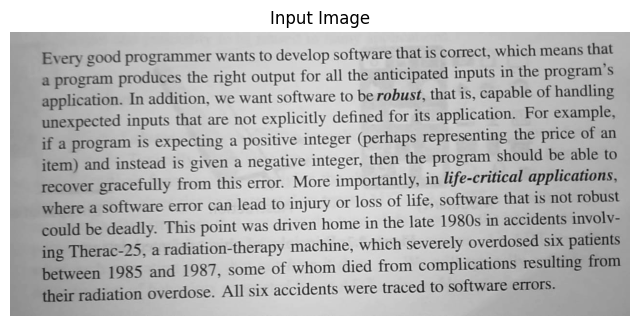

In [86]:
Plotter.PlotImage(img, title="Input Image")

### Filtering Input Image

- Unsharp Masking (USM)
- High-boost Filter


In [87]:
from src.image_processor.filters import *

In [88]:
unsharp_filter = FilterBuilder.Build(FilterType.UNSHARP_MASKING, strength=1.5)
unsharp_img =  unsharp_filter.Filter(img)

highboost_filter = FilterBuilder.Build(FilterType.HIGH_BOOST, A=1.7)
highboost_img = highboost_filter.Filter(img)

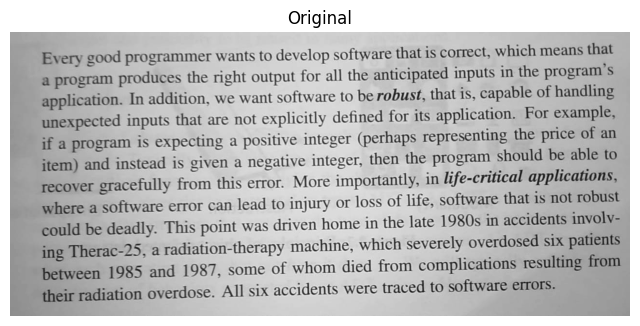

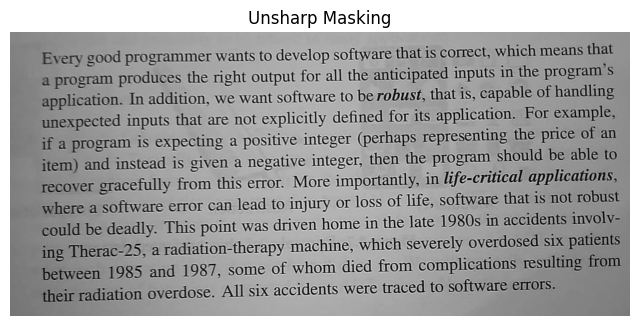

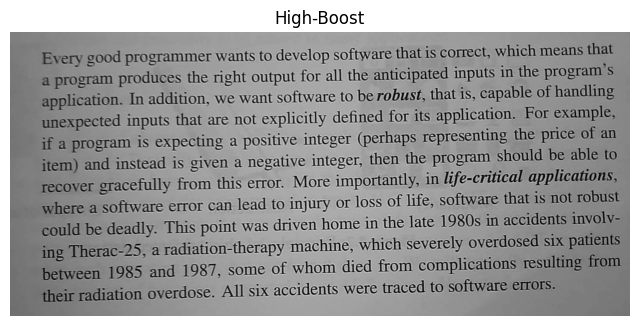

In [89]:
titles = ["Original", "Unsharp Masking", "High-Boost"]
images = [img, unsharp_img, highboost_img]

for i, (title, img) in enumerate(zip(titles, images)):
    Plotter.PlotImage(img, title=title)


**Note:** USM produces the best result, hence it is used in further steps.

In [90]:
filtered_img = unsharp_img

### Threasholding Filtered (Sharpened) Image

- Adaptive Gaussian Thresholding
- Otsu's Method
- Mode: Binary Inverted 

In [91]:
from src.image_processor.thresholding import *

In [92]:
adaptive_gaussian_thresh = ThresholdingBuilder.Build(
    ThresholdingType.ADAPTIVE_GAUSSIAN, 
    ThresholdingMode.BINARY_INV,
    sigma=1.0,
    block_size=11,
    C=2.0,
    max_value=255.0
)
adaptive_gaussian_thresh_img = adaptive_gaussian_thresh.ApplyThresholding(filtered_img)

otsu_thresh = ThresholdingBuilder.Build(
    ThresholdingType.OTSU,
    ThresholdingMode.BINARY_INV,
    max_value=255.0
)
otsu_thresh_img = otsu_thresh.ApplyThresholding(filtered_img)

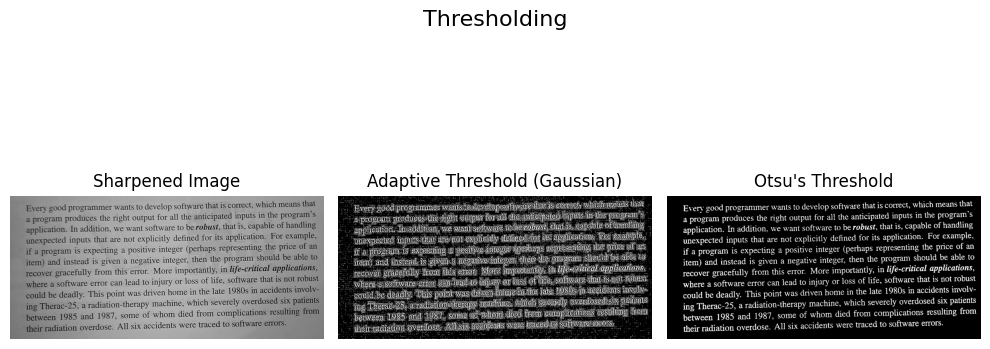

In [93]:
Plotter.PlotImages(
    [
        filtered_img,
        adaptive_gaussian_thresh_img,
        otsu_thresh_img,
    ],
    "Thresholding",
    ["Sharpened Image", "Adaptive Threshold (Gaussian)", "Otsu's Threshold"],
)

**Note:** Clearly, Otsu produces the best result here...

In [94]:
thresh_img = otsu_thresh_img

### Aligning the Thresholded Image

In [95]:
from src.utils import Aligner

In [96]:
aligned_img = Aligner.DeskewTextHorizontal(thresh_img)


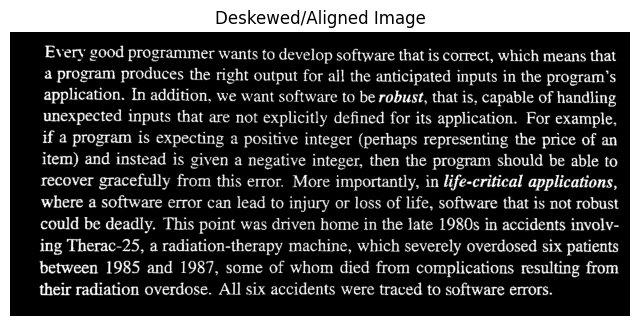

In [97]:
Plotter.PlotImage(aligned_img, title="Deskewed/Aligned Image")

In [98]:
save_img = False

In [99]:
if save_img:
    cv2.imwrite("./assets/test_deskewed.jpg", aligned_img)

### Segmentation of Aligned Image

- Line Segmentation (HPP)
- Word Segmentation (VPP)
- Character Segmentation (CCA)

In [100]:
from src.image_processor.segmentation import *

In [101]:
lines = SegmentationBuilder.Build(SegmentationType.HPP).Segment(aligned_img)
words = SegmentationBuilder.Build(SegmentationType.VPP).Segment(lines[0])
chars = SegmentationBuilder.Build(SegmentationType.CCA).Segment(words[0])

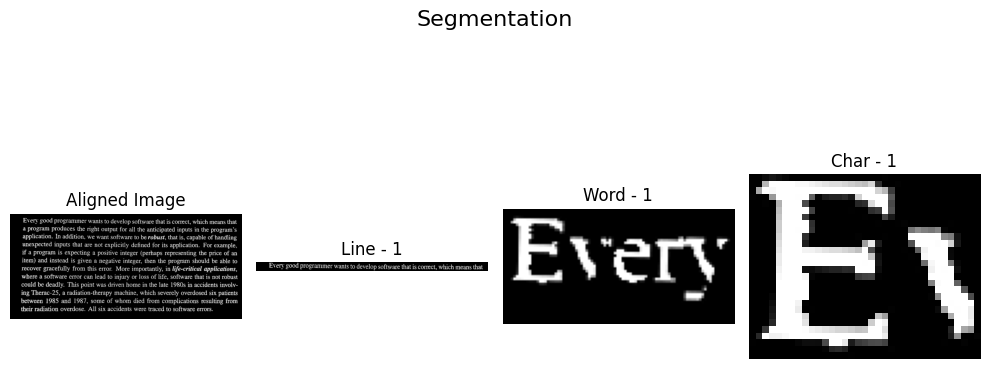

In [102]:
Plotter.PlotImages(
    [aligned_img, lines[0], words[0], chars[0]],
    "Segmentation",
    ["Aligned Image", "Line - 1", "Word - 1", "Char - 1"],
)

### Using the ImageProcessor Pipeline

In [103]:
from src.pipelines import ImageProcessor

In [104]:
img_proc = ImageProcessor(PATH)

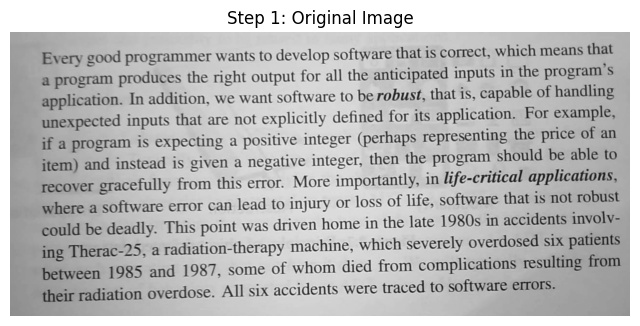

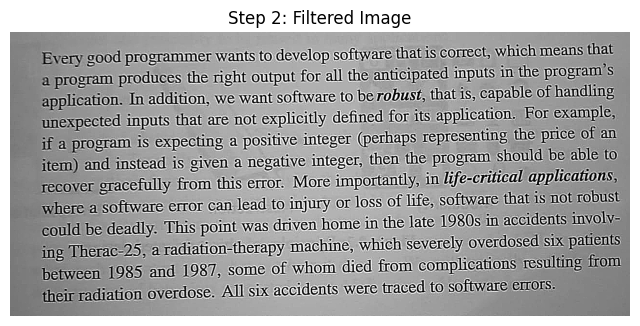

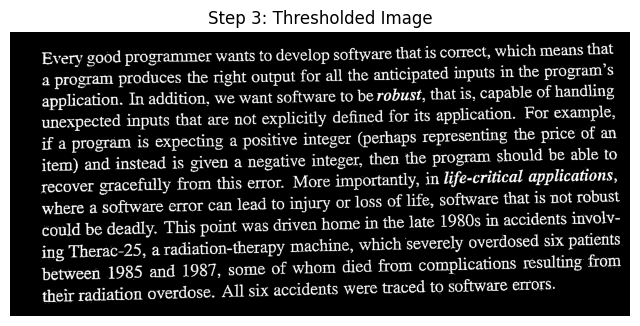

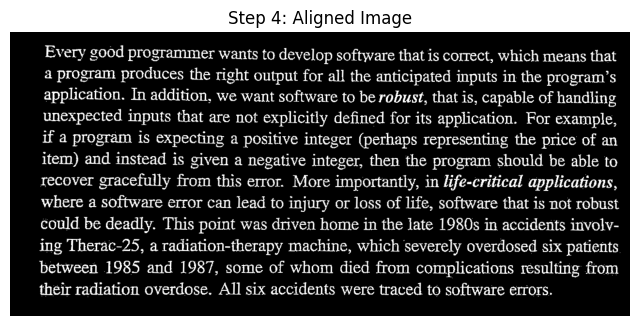

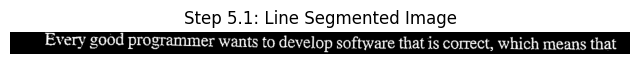

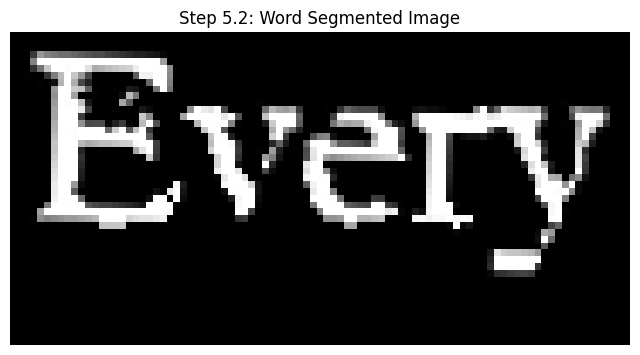

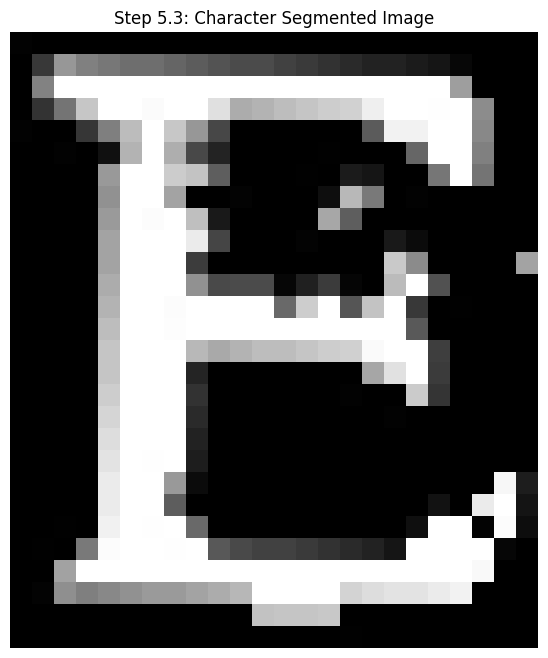

In [105]:
result = (
    img_proc
    .Plot(title="Step 1: Original Image")
    .Filter(FilterType.UNSHARP_MASKING, sigma=1.5, strength=5.0)
    .Plot(title="Step 2: Filtered Image")
    .Threshold(ThresholdingType.OTSU, ThresholdingMode.BINARY_INV)
    .Plot(title="Step 3: Thresholded Image")
    .Align()
    .Plot(title="Step 4: Aligned Image")
    .SegmentIntoLines()
    .PlotSegmentLine(index=0, title="Step 5.1: Line Segmented Image")
    .SegmentIntoWords(line_index=0)
    .PlotSegmentWord(index=0, title="Step 5.2: Word Segmented Image")
    .SegmentIntoChars(word_index=0)
    .PlotSegmentChar(index=0, title="Step 5.3: Character Segmented Image")
)

### OCR Evaluation: PyTesseract vs PaddleOCR

In [106]:
import pytesseract
from paddleocr import PaddleOCR
from tabulate import tabulate

In [107]:
# First Line (Segmented Image Text) of Text Image
sample = (
    "a program produces the right output for all the anticipated inputs in the program's"
)
ocr_input = lines[1]

print(" => Input Text:")
print(sample)

 => Input Text:
a program produces the right output for all the anticipated inputs in the program's


In [108]:
paddle_ocr = PaddleOCR(
    use_angle_cls=True,
    lang="en",
)
output_paddle = paddle_ocr.ocr(ocr_input)

[2025/10/07 01:31:34] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, shape_info_filename=None, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\Ankur Majumdar/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\Ankur Majumdar/.paddleocr/whl\\rec\\en\\en_PP-OCRv3_rec_infer', rec_image_shape='3, 48,

In [109]:
output_paddle = " ".join([line[1][0] for line in output_paddle])

print(" => Paddle OCR Output:")
print(output_paddle)

 => Paddle OCR Output:
a program produces the right output for all the anticipated inputs in the program's


In [110]:
output_tesseract = pytesseract.image_to_string(ocr_input)

print(" => Py-Tesseract OCR Output:")
print(output_tesseract)

 => Py-Tesseract OCR Output:
a program produces the right output for all the anticipated inputs in the program’s



##### Similarity Measures

- Cosine Similarity
- Hamming Distance
- Levenshtein Distance

In [111]:
cos_paddle = CVMath.CosineSimilarity(sample, output_paddle)
ham_paddle = CVMath.HammingDistance(sample, output_paddle)
lev_paddle = CVMath.LevenshteinDistance(sample, output_paddle)

cos_tesseract = CVMath.CosineSimilarity(sample, output_tesseract)
ham_tesseract = CVMath.HammingDistance(sample, output_tesseract)
lev_tesseract = CVMath.LevenshteinDistance(sample, output_tesseract)

In [114]:
table = [
    ["PyTesseract-OCR", output_tesseract, round(cos_tesseract, 3), ham_paddle, lev_paddle],
    ["Paddle-OCR", output_paddle, round(cos_paddle, 3), ham_paddle, lev_paddle],
]

headers = [
    "OCR Engine", 
    "Extracted Text", 
    "Cosine Similarity",
    "Hamming Distance",
    "Levenshtein Distance"
]

print(tabulate(table, headers=headers, tablefmt="github"))

| OCR Engine      | Extracted Text                                                                      |   Cosine Similarity |   Hamming Distance |   Levenshtein Distance |
|-----------------|-------------------------------------------------------------------------------------|---------------------|--------------------|------------------------|
| PyTesseract-OCR | a program produces the right output for all the anticipated inputs in the program’s |               0.153 |                  0 |                      0 |
| Paddle-OCR      | a program produces the right output for all the anticipated inputs in the program's |               1     |                  0 |                      0 |
